In [1]:
import numpy
import math
import pandas
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#from sklearn.utils import check_arrays

from sklearn.svm import SVR
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout

Using TensorFlow backend.


In [2]:
numpy.random.seed(7)

dataframe = pandas.read_csv('Paper66_10min.csv', header=None)
dataframe = dataframe.iloc[:, [1,2,4,5,6,7,9,11]]
dataset = dataframe.values
dataset = dataset.astype('float32')

#summary of data
Data_Summary = numpy.zeros((8,3))

for i in range (len(dataset[0, :])):
    Data_Summary[i,0] = numpy.max(dataset[:, i])
    Data_Summary[i,1] = numpy.mean(dataset[:, i])
    Data_Summary[i,2] = numpy.std(dataset[:, i])

print (Data_Summary)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

[[ 1.77149999  0.19888213  0.10472103]
 [ 1.13699996  0.12350018  0.13087003]
 [ 1.14999998  0.23069003  0.27148944]
 [ 0.74599999  0.06392039  0.06839383]
 [ 1.14300001  0.55704874  0.37750435]
 [ 3.29500008  1.46453643  1.03900933]
 [ 0.96950001  0.17980404  0.17077641]
 [ 1.6595      0.27750552  0.35760996]]


In [3]:
#train, test split
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [4]:
def create_dataset(dataset, look_back, step):
    dataX, dataY = [], []
    
    for i in range(len(dataset)-look_back-step): #i是矩阵的列数
        a = numpy.reshape(dataset[i:(i+look_back), :], -1)
        dataX.append(a)
        b = numpy.reshape(dataset[i+look_back+step-1, :], -1)
        dataY.append(b)
    
    return numpy.array(dataX), numpy.array(dataY)

#Nash-Sutcliffe
def NSE(observed, simulated):
    return 1 - numpy.sum((simulated-observed)**2)/numpy.sum((observed-numpy.mean(observed))**2)

def mean_absolute_percentage_error(y_true, y_pred): 
    return numpy.mean(numpy.abs((y_true - y_pred) / y_true)) * 100

In [5]:
look_back = 48
step = 8

TrainX, TrainY = create_dataset(train, look_back, step)
TestX, TestY = create_dataset(test, look_back, step)

In [6]:
TrainX = numpy.reshape(TrainX, (TrainX.shape[0], 1, TrainX.shape[1]))
TestX = numpy.reshape(TestX, (TestX.shape[0], 1, TestX.shape[1]))

RNN = Sequential()
RNN.add(SimpleRNN(512, return_sequences=True, input_dim=8*look_back))
RNN.add(Dropout(0.2))
RNN.add(SimpleRNN(512))
RNN.add(Dense(8))
RNN.compile(loss='mean_squared_error', optimizer='adam')
RNN.fit(TrainX, TrainY, nb_epoch=60, batch_size=1024, verbose=2)

RNNpredict = RNN.predict(TestX)

RNNpredict = scaler.inverse_transform(RNNpredict)
TestY = scaler.inverse_transform(TestY)

Epoch 1/60
12s - loss: 0.2005
Epoch 2/60
11s - loss: 0.0324
Epoch 3/60
12s - loss: 0.0168
Epoch 4/60
11s - loss: 0.0129
Epoch 5/60
11s - loss: 0.0109
Epoch 6/60
11s - loss: 0.0097
Epoch 7/60
14s - loss: 0.0089
Epoch 8/60
13s - loss: 0.0083
Epoch 9/60
11s - loss: 0.0079
Epoch 10/60
11s - loss: 0.0076
Epoch 11/60
11s - loss: 0.0074
Epoch 12/60
11s - loss: 0.0073
Epoch 13/60
11s - loss: 0.0071
Epoch 14/60
14s - loss: 0.0069
Epoch 15/60
11s - loss: 0.0069
Epoch 16/60
11s - loss: 0.0068
Epoch 17/60
9s - loss: 0.0067
Epoch 18/60
12s - loss: 0.0067
Epoch 19/60
14s - loss: 0.0066
Epoch 20/60
11s - loss: 0.0066
Epoch 21/60
12s - loss: 0.0065
Epoch 22/60
11s - loss: 0.0065
Epoch 23/60
11s - loss: 0.0065
Epoch 24/60
11s - loss: 0.0064
Epoch 25/60
11s - loss: 0.0064
Epoch 26/60
13s - loss: 0.0064
Epoch 27/60
11s - loss: 0.0064
Epoch 28/60
10s - loss: 0.0064
Epoch 29/60
9s - loss: 0.0063
Epoch 30/60
10s - loss: 0.0063
Epoch 31/60
13s - loss: 0.0063
Epoch 32/60
12s - loss: 0.0062
Epoch 33/60
11s - l

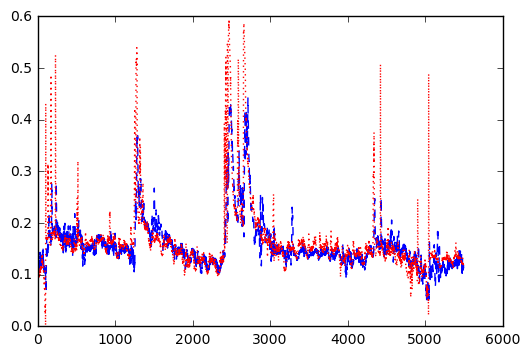

In [7]:
plt.plot(RNNpredict[:,0],'b--')
plt.plot(TestY[:,0],'r:',markersize=3)

plt.show()

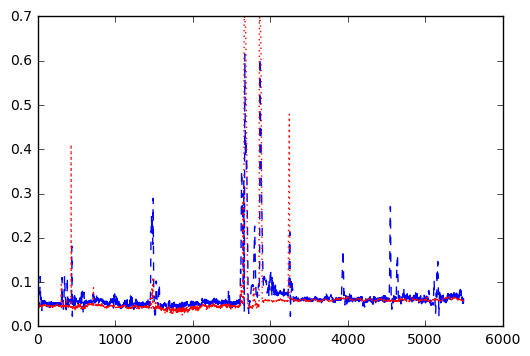

In [12]:
plt.plot(RNNpredict[:,3],'b--')
plt.plot(TestY[:,3],'r:',markersize=3)

plt.show()

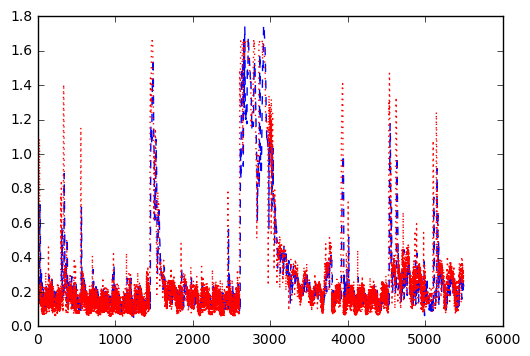

In [9]:
plt.plot(RNNpredict[:,7],'b--')
plt.plot(TestY[:,7],'r:',markersize=3)

plt.show()

In [10]:
Model_Result = numpy.zeros((8,3))

for i in range (len(dataset[0, :])):
    Model_Result[i,0] = numpy.corrcoef(TestY[:,i], RNNpredict[:,i])[0, 1]
    Model_Result[i,1] = numpy.sqrt(mean_squared_error(TestY[:,i], RNNpredict[:,i]))
    Model_Result[i,2] = NSE(TestY[:,i], RNNpredict[:,i])
    #Model_Result[i,2] = mean_absolute_percentage_error(TestY[:,i], LSTMpredict[:,i])

print (Model_Result)

[[ 0.73274285  0.04514832  0.53327414]
 [ 0.73890285  0.05950008  0.50792333]
 [ 0.96495601  0.08304146  0.91458634]
 [ 0.71580394  0.04829601  0.49895155]
 [ 0.94709815  0.07625654  0.87935365]
 [ 0.97749956  0.15710306  0.94634991]
 [ 0.85210206  0.07855706  0.72530615]
 [ 0.88221878  0.1823971   0.77311872]]
